# setting up the training data

56
This choice will generate autonomous dynamics
No change  applied to TS or repr data


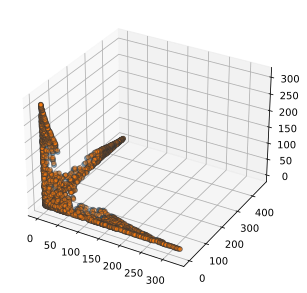

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np
from models.training import create_dataloader, maskedTrainer


# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 

torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

# design choices 
chosen_problem = 'repressilator'
data_noise = 0.
n_different_weights = 1
if n_different_weights == 1:
    print('This choice will generate autonomous dynamics')
else:
    print('This choice generates non-autonomous dynamics, letting the weights depend on time')

possible_problem = {'moons':'moons', 'ToggleSwitch':'TS', 'repressilator':'repr', 'restricted_TS': 'restrictedTS'} 
# this choices determine the data set that we build and subsequent choices on the construction of the neural ODE 
# - in particular, it determines the dimensions 
problem = possible_problem[chosen_problem]

plotlim = [0, 5]

dataloader, dataloader_viz = create_dataloader(problem, batch_size = 2000, noise = data_noise, 
                                               plotlim = plotlim, random_state = seed, label = 'vector')

# setting up the nODE architecture

In [2]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 1, n_different_weights
bound = 0.
fp = False
cross_entropy = False
turnpike = False

# choice of model: what nonlinearity is used and if the nonlinearity is applied before (inside) or after (outside) the linear weights
# another choice is bottleneck, but I don't understand it
# non_linearity = 'tanh' # OR 'relu' 'sigmoid' 'leakyrelu' 'tanh_prime'
# architecture = 'inside' 'outside'
non_linearity = 'tanh'
architecture = 'inside'
architectures = {'inside': -1, 'outside': 0, 'bottleneck': 1, 'restricted': 2}
# number of optimization runs in which the dataset is used for gradient decent
num_epochs = 50
if problem == 'moons' or problem == 'TS' or problem == "restrictedTS":
    hidden_dim, data_dim = 2, 2 
else:
    hidden_dim, data_dim = 3, 3 
augment_dim = 0

# resets the seed - allows for coherent runs in the gradient descent as well
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
node = NeuralODE(device, data_dim, hidden_dim, output_dim=data_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_node = torch.optim.Adam(node.parameters(), lr=1e-1) 

# training phase with mask

In [3]:
# explicit mask for the repressilator
mask = torch.Tensor([[0,0.,1.0],[1.0,0,0.],[0,1.0,0]]) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
trainer = maskedTrainer(node, optimizer_node, device, mask, cross_entropy=cross_entropy,
                         bound=bound, verbose = True) 

In [12]:
trainer.train(dataloader, 60)


Iteration 0/25
Loss: 6.216
Masked loss: 0.667

Iteration 10/25
Loss: 6.187
Masked loss: 0.671

Iteration 20/25
Loss: 6.812
Masked loss: 0.464
Epoch 1: 5.989

Iteration 0/25
Loss: 4.907
Masked loss: 0.524

Iteration 10/25
Loss: 5.555
Masked loss: 0.445

Iteration 20/25
Loss: 5.156
Masked loss: 0.416
Epoch 2: 5.828

Iteration 0/25
Loss: 4.861
Masked loss: 0.244

Iteration 10/25
Loss: 5.479
Masked loss: 0.295

Iteration 20/25
Loss: 4.362
Masked loss: 0.299
Epoch 3: 5.520

Iteration 0/25
Loss: 5.113
Masked loss: 0.294

Iteration 10/25
Loss: 6.165
Masked loss: 0.242

Iteration 20/25
Loss: 5.659
Masked loss: 0.273
Epoch 4: 5.319

Iteration 0/25
Loss: 4.977
Masked loss: 0.346

Iteration 10/25
Loss: 4.621
Masked loss: 0.201

Iteration 20/25
Loss: 5.086
Masked loss: 0.374
Epoch 5: 5.353

Iteration 0/25
Loss: 4.854
Masked loss: 0.212

Iteration 10/25
Loss: 5.344
Masked loss: 0.174

Iteration 20/25
Loss: 4.982
Masked loss: 0.147
Epoch 6: 5.067

Iteration 0/25
Loss: 5.552
Masked loss: 0.137

Iter

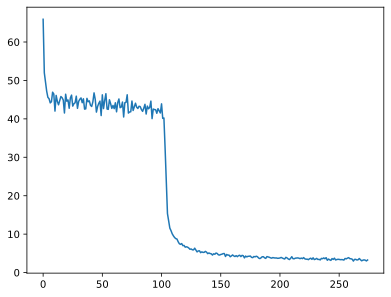

In [13]:
plt.plot(trainer.histories['loss_history'])

In [14]:
trainer.model.flow.dynamics.fc2_time[0].weight 

Parameter containing:
tensor([[ 3.0345e-02,  3.7349e-03, -2.0328e+01],
        [-2.5930e+01,  4.0524e-02,  2.5836e-02],
        [-2.8814e-02, -1.9076e+01,  6.0802e-02]], requires_grad=True)

In [15]:
trainer.model.flow.dynamics.fc2_time[0].bias

Parameter containing:
tensor([19.3862, 24.9474, 18.0717], requires_grad=True)

In [7]:
mask

tensor([[0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.]])

In [8]:
(trainer.model.flow.dynamics.fc2_time[0].weight * (1 - trainer.mask)).norm(1)

tensor(0.6674, grad_fn=<LinalgVectorNormBackward0>)

In [9]:
node.forward(torch.Tensor([1.,2.,3.]))[0].detach()

tensor([-0.2443, 13.8330,  1.5146])

In [10]:
low, high = plotlim  # range of uniform distribution
X = np.array(torch.distributions.uniform.Uniform(low, high).sample(size))
for x in X:
    y = node.forward(torch.Tensor(x))[0].detach()

NameError: name 'size' is not defined